<a href="https://colab.research.google.com/github/one-gidung/AI_CAMP/blob/study/04_03_rnn_%EA%B0%95%EC%9D%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evn

In [28]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [29]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [30]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 입력 및 Vocab

In [31]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [32]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [33]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [34]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [35]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False

In [36]:
# rnn
rnn_11 = tf.keras.layers.SimpleRNN(units=5)
output_11 = rnn_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[ 0.0133051  -0.07108931  0.01356496  0.19825453 -0.03756267]], shape=(1, 5), dtype=float32)


In [37]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)     # (d_model, unit)
print(Wh.shape)     # (unit, unit)
print(b.shape)      # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [38]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True)
output_12 = rnn_12(hidden)      # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 2.9929113e-02  4.1185715e-03 -7.3335785e-03 -2.7490623e-02
   -4.2592518e-02]
  [ 2.1723522e-02  3.4244298e-03 -8.8698808e-03  1.3401901e-02
   -2.1286123e-02]
  [ 4.8892803e-02 -1.5492372e-02  5.2009160e-03 -5.0389312e-02
   -6.7127943e-02]
  [ 5.3107738e-02  3.3684172e-02  4.7106575e-02  2.6926834e-02
   -1.6819069e-02]
  [ 6.6921949e-02 -6.2659383e-06  3.1169422e-02 -2.7292369e-02
    2.3001337e-02]
  [ 5.5012092e-02 -4.9766455e-02 -4.8280213e-02  2.3197087e-02
    1.8371815e-02]
  [ 1.5149739e-02 -9.3269765e-02  1.8400183e-02  7.5476407e-04
   -6.5119125e-02]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [39]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units=5, return_state=True)
output_13, fw_h_13 = rnn_13(hidden)      # (bs, seq, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525434 -0.12735648]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525434 -0.12735648]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [40]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = rnn_14(hidden)  # (bs, seq, units), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[-0.00567131  0.00702238  0.0166551  -0.02649674 -0.00639815]
  [ 0.00745121  0.00397363 -0.03161482  0.00067732  0.03525217]
  [ 0.02503373  0.04381724 -0.01435504 -0.07607194 -0.03647323]
  [ 0.03158387 -0.03594297 -0.03295876  0.09170678  0.00911083]
  [-0.06396969  0.06692141  0.02803503 -0.07891872 -0.05069153]
  [ 0.03279418 -0.04417153 -0.09341431  0.0333666   0.09773416]
  [ 0.01325146  0.01543665  0.01574938 -0.08289386 -0.10723303]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01325146  0.01543665  0.01574938 -0.08289386 -0.10723303]], shape=(1, 5), dtype=float32)


## init hidden state

In [41]:
# rnn_11 with fw_h_13
rnn_11(hidden, initial_state=[fw_h_13])     # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.06465904, -0.25594386, -0.12518847,  0.13231519, -0.02561215]],
      dtype=float32)>

In [42]:
# rnn_12 with fw_h_14
rnn_12(hidden, initial_state=[fw_h_14])     # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.08970518,  0.12074085,  0.02214284, -0.00741253,
         -0.06301705],
        [ 0.06890634,  0.02803107,  0.03387965, -0.06119582,
          0.07141123],
        [ 0.13040169, -0.04140752, -0.09347053, -0.06496175,
         -0.03006374],
        [ 0.11627129, -0.0390062 ,  0.06014571, -0.02257581,
         -0.09820992],
        [ 0.14631155,  0.0332644 ,  0.08039215,  0.05096842,
         -0.0258085 ],
        [ 0.08789143, -0.06898136,  0.05173643,  0.0284674 ,
          0.1006607 ],
        [ 0.04806692, -0.15309522, -0.04242581,  0.05481387,
          0.01750817]]], dtype=float32)>

In [43]:
# rnn_13 with fw_h_13
rnn_13(hidden, initial_state=[fw_h_13])     # (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090795, -0.01084654,  0.00649465,  0.03989044,  0.08458714]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090795, -0.01084654,  0.00649465,  0.03989044,  0.08458714]],
       dtype=float32)>]

In [44]:
# rnn_14 with fw_h_14
rnn_14(hidden, initial_state=[fw_h_14])     # (bs, n_seq,  units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.04023583, -0.04856527, -0.00745723,  0.08569601,
           0.03263333],
         [-0.03993218,  0.04022601, -0.0133417 , -0.1201784 ,
           0.01704529],
         [ 0.08773063, -0.04925723, -0.03939974, -0.01440458,
           0.00531509],
         [-0.01835137,  0.00441733,  0.04440122,  0.04724793,
          -0.07235702],
         [-0.06754464,  0.03039353,  0.0077003 , -0.02238409,
           0.0663793 ],
         [ 0.07404423, -0.00928033, -0.04943877, -0.06849191,
           0.03991261],
         [ 0.03545617, -0.01660541,  0.01871964,  0.04337611,
          -0.07521319]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03545617, -0.01660541,  0.01871964,  0.04337611, -0.07521319]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [45]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units=5)
output_11 = lstm_11(hidden)     # (bs, units)
print(output_11)

tf.Tensor([[ 0.01252828 -0.01186483 -0.01100005  0.00128962  0.00689079]], shape=(1, 5), dtype=float32)


In [46]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)     # (d_model, )
print(Wh.shape)     # () ()
print(b.shape)      # () ()

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [50]:
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units=5, return_sequences=True)
output_12 = lstm_12(hidden)     # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00109647  0.003973    0.00491607  0.00434578 -0.00010082]
  [ 0.00348979  0.00353155  0.00068605 -0.00139282  0.00037354]
  [ 0.00375388  0.00900979  0.00461504  0.00242298  0.00143028]
  [ 0.00433982  0.00436818  0.00329972  0.00142956  0.00094539]
  [ 0.00166688  0.00650878  0.00713827  0.00487696  0.0003925 ]
  [ 0.00533907  0.00496987  0.00216444 -0.00129159  0.00064027]
  [ 0.00699196  0.00437341  0.0025941  -0.0012665   0.00110581]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [49]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units=5, return_state=True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden)   # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor([[-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.00723412 -0.0093214   0.01380899 -0.01084146 -0.00508808]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [51]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden)   # (bs, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)

tf.Tensor(
[[[-0.00031232  0.00035    -0.00602605  0.00325187  0.00500193]
  [ 0.00191611 -0.00246147 -0.00247776 -0.00149736  0.00335464]
  [ 0.00395028 -0.00199805 -0.01084031  0.00352603  0.01166661]
  [ 0.00885272  0.00383132 -0.00738862  0.00178646  0.00752748]
  [ 0.00712753  0.00394021 -0.01201764  0.00329205  0.01241342]
  [ 0.00850007  0.00089784 -0.00745089 -0.00247206  0.01025239]
  [ 0.01270817  0.00426247 -0.00694759 -0.00339906  0.00714147]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01270817  0.00426247 -0.00694759 -0.00339906  0.00714147]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.02524673  0.00855356 -0.0138775  -0.00675537  0.01418354]], shape=(1, 5), dtype=float32)


## init hidden state

In [52]:
# lstm_11 with fw_h_13, fw_c_13
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.0120116 , -0.0123648 , -0.009679  ,  0.00262885,  0.00523614]],
      dtype=float32)>

In [53]:
# lstm_12 with fw_h_14, fw_c_14
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.00766923,  0.00615799, -0.0025638 ,  0.00052559,
          0.0054172 ],
        [ 0.00987268,  0.00455721, -0.00670599, -0.00508183,
          0.00482441],
        [ 0.00833161,  0.00945224, -0.00234016, -0.00081134,
          0.00505778],
        [ 0.0077551 ,  0.00448535, -0.00308765, -0.00139938,
          0.00385202],
        [ 0.00417341,  0.0064891 ,  0.0013025 ,  0.00255506,
          0.00282388],
        [ 0.00726293,  0.00490012, -0.00302236, -0.00319831,
          0.00268472],
        [ 0.00844671,  0.0042928 , -0.00194969, -0.0027929 ,
          0.00277785]]], dtype=float32)>

In [54]:
# lstm_13 with fw_h_13, fw_c_13
lstm_13(hidden, initial_state=[fw_h_13, fw_c_14])  # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00151539, -0.0035343 ,  0.00563714, -0.00501237, -0.00311991]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00151539, -0.0035343 ,  0.00563714, -0.00501237, -0.00311991]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00302914, -0.0070052 ,  0.01126258, -0.01000674, -0.00626439]],
       dtype=float32)>]

In [55]:
# lstm_14 with fw_h_14, fw_c_14
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.01049861,  0.00422002, -0.0119902 , -0.00063109,
           0.01185338],
         [ 0.01149647,  0.00107674, -0.00764428, -0.00555346,
           0.00965519],
         [ 0.01228009,  0.00118572, -0.01549886, -0.00051208,
           0.01758492],
         [ 0.01631672,  0.00664485, -0.01156615, -0.0020623 ,
           0.01285674],
         [ 0.01368803,  0.0064662 , -0.01578252, -0.00031173,
           0.01728946],
         [ 0.0144625 ,  0.00318704, -0.01082227, -0.00584687,
           0.01459741],
         [ 0.01805097,  0.00629043, -0.01002929, -0.00652198,
           0.0110887 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01805097,  0.00629043, -0.01002929, -0.00652198,  0.0110887 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03584805,  0.0126378 , -0.02004248, -0.01297265,  0.02199908]],
       dtype=float32)>]

# GRU

## return sequence=False, return_state=False

In [ ]:
# GRU

In [ ]:
# GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00140842,  0.01592344, -0.01623747, -0.00670336, -0.01101907]],
      dtype=float32)>

In [ ]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00300019, -0.00323922, -0.01454308, -0.00958822,
          0.01849951],
        [-0.00319965, -0.00230684, -0.00040348,  0.0188137 ,
          0.02772161],
        [-0.01684529, -0.02090497, -0.00366238,  0.02805248,
          0.04653085],
        [-0.00582952, -0.00502904,  0.00368652,  0.0209058 ,
          0.02341765],
        [-0.01303946, -0.01359165, -0.00516605,  0.01199155,
          0.02483771],
        [-0.01180617, -0.00767625,  0.00535123,  0.03328608,
          0.03071455],
        [-0.00979845, -0.00366684,  0.01045386,  0.03020769,
          0.02639962]]], dtype=float32)>

In [ ]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>]

In [ ]:
gru_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.00120912,  0.01436689, -0.00526015, -0.00245608,
           0.01752719],
         [ 0.00106435,  0.0148916 , -0.01622299, -0.01184704,
           0.01214018],
         [ 0.00249824,  0.02077618, -0.01704834, -0.01405097,
           0.03059548],
         [ 0.01132524,  0.01315177, -0.01130751, -0.0072835 ,
           0.01345716],
         [ 0.00543236,  0.0139883 , -0.00539421, -0.00206096,
           0.01916937],
         [ 0.00361664,  0.0148993 , -0.01673315, -0.01203724,
           0.01301165],
         [ 0.00488993,  0.01504152, -0.01344696, -0.01023171,
           0.01024941]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00488993,  0.01504152, -0.01344696, -0.01023171,  0.01024941]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [56]:
# bi rnn
# rnn_11 = tf.keras.layers.SimpleRNN(units=5)
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5))
output_11 = bi_rnn_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.10336562  0.08199173 -0.09182289 -0.00289055  0.17580172  0.05653751
  -0.03108167 -0.00434958  0.02248471 -0.02679492]], shape=(1, 10), dtype=float32)


In [58]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [59]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True))
output_12 = bi_rnn_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.02063903  0.03965816  0.03919788  0.02908318 -0.02135444
    0.03373569  0.14357285  0.02265848 -0.01834988  0.01760596]
  [-0.06732997  0.0119262   0.01037599  0.03202324 -0.04788924
   -0.02202282 -0.12320485  0.00310691  0.03954257  0.02772265]
  [-0.0069248   0.09928044  0.00049278  0.0842956  -0.02588288
    0.02357069  0.03469789  0.06235293 -0.08903261  0.01622928]
  [-0.10489257  0.04832265  0.01487477  0.05294417  0.00262039
   -0.02221388 -0.06631253 -0.00934883  0.01024336  0.03339538]
  [-0.02521386  0.11432075  0.0165207   0.04469954  0.06719342
    0.04058785  0.02231554 -0.00393319 -0.01607522  0.03056315]
  [-0.08703329  0.0155736   0.07161146  0.08565228  0.04799198
    0.02592861 -0.0405432  -0.03698469 -0.03118086  0.01623693]
  [-0.0069922   0.11693995  0.02447139  0.02125133  0.06086859
   -0.0062323  -0.04051992 -0.00674628 -0.02538863 -0.00846069]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [60]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[ 0.10142464  0.04384788  0.03959855  0.09941956  0.05877534  0.19237266
  -0.0812621   0.04585575  0.21233375 -0.06199192]], shape=(1, 10), dtype=float32)
tf.Tensor([[0.10142464 0.04384788 0.03959855 0.09941956 0.05877534]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.19237266 -0.0812621   0.04585575  0.21233375 -0.06199192]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [61]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.01223004 -0.03604717 -0.01213866  0.00832459 -0.00985193
   -0.06842467  0.03804656 -0.21594404 -0.07498586  0.12322078]
  [-0.01207433 -0.02585809  0.01065563  0.01178059 -0.05265585
    0.07812028 -0.15373422 -0.00190183 -0.13922727  0.13310388]
  [-0.0369997  -0.07803842  0.04209687  0.04328766 -0.0377161
    0.07696803  0.08312834 -0.0637846  -0.02303878  0.17275529]
  [-0.03149062 -0.00641296  0.09045608  0.04872282 -0.02032937
   -0.06239615 -0.07913799  0.00644676 -0.02948124  0.07311696]
  [-0.00251457  0.00482455  0.03361512  0.09806919 -0.01537912
    0.00374245  0.03065289 -0.0893319  -0.05894311  0.0406061 ]
  [ 0.06832523  0.01860224  0.02926934  0.06120522 -0.07875361
    0.03820577 -0.03235298  0.02452953 -0.05579672  0.06007537]
  [ 0.07677121  0.03446358  0.09452506 -0.03025864  0.00149059
    0.02181129  0.02294274 -0.00379264 -0.01796763  0.03280125]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.07677121  0.03446358  0.09452506 -0.03025864  0.00

## init hidden state

In [62]:
# bi_rnn_11 with fw_h_13, bw_h_13
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.03366552,  0.02708556, -0.08833596,  0.02204747,  0.11622974,
        -0.09725527, -0.23567978, -0.14445539,  0.18366566, -0.04445881]],
      dtype=float32)>

In [63]:
# bi_rnn_12 with fw_h_14, bw_h_14
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00958689,  0.03306837,  0.121411  , -0.05310354,
         -0.069801  , -0.00270117,  0.3421622 ,  0.0594316 ,
          0.04920284, -0.08195023],
        [-0.08903914, -0.00823849, -0.0190354 , -0.08953566,
         -0.03271431, -0.14414804, -0.26751798,  0.14107466,
          0.11605854, -0.01104443],
        [ 0.02232581, -0.00883719, -0.02639926,  0.04660335,
          0.01856824,  0.02391086,  0.2328768 ,  0.21018218,
         -0.13730294,  0.04852048],
        [ 0.01353182,  0.0045039 ,  0.00479941,  0.05030999,
         -0.02010383, -0.12037753, -0.16119115,  0.04842468,
          0.18212932,  0.15873075],
        [ 0.00532184,  0.08084926,  0.03913519,  0.04759575,
         -0.05087128,  0.16545373,  0.07834654,  0.14952204,
         -0.1347118 ,  0.14144842],
        [-0.11827581,  0.02918995,  0.00035898,  0.04068657,
         -0.04247621, -0.04291085, -0.0464942 , -0.14875293,
          0.07161848,  0.22109677],


In [ ]:
# bi_rnn_13 with fw_h_13, bw_h_13

In [ ]:
# bi_rnn_14 with fw_h_14, bw_h_14

# Bidirectional LSTM

## return sequence=False, return_state=False

In [69]:
# lstm
bi_lstm_11 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5))
output_11 = bi_lstm_11(hidden)  # (bs, seq, units * 2)
print(output_11)

tf.Tensor(
[[-0.0091411  -0.00195886 -0.01065393  0.00111449  0.00126692  0.00095727
  -0.00672461  0.00755316 -0.00082623 -0.00279788]], shape=(1, 10), dtype=float32)


In [70]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [71]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True))
output_12 = bi_lstm_12(hidden)  # (bs, seq, units * 2)
print(output_12)

tf.Tensor(
[[[-0.00265786 -0.0043344   0.00013482  0.00021896  0.00235112
    0.01547839  0.00376636 -0.00398766 -0.00370576 -0.00819959]
  [-0.00449128 -0.00437867 -0.00593121  0.00924517  0.00283331
    0.01751981  0.0049557  -0.00431832 -0.00138006 -0.00634429]
  [-0.00937262 -0.01305849 -0.00901041  0.01327662  0.00807199
    0.01378284  0.00387323 -0.00220566  0.00160091 -0.00953445]
  [-0.00559793 -0.01018761 -0.00705128  0.00901377  0.00187473
    0.00511518  0.00353836 -0.00231105  0.00052435 -0.00378776]
  [-0.00693194 -0.01262938 -0.00397775  0.00756546  0.003328
    0.00971271  0.00036867 -0.00292887 -0.00174154 -0.00260874]
  [-0.00763143 -0.01133148 -0.0081919   0.01510806  0.00309236
    0.0093383   0.00124105 -0.00361729 -0.00029563  0.00060674]
  [-0.00669851 -0.01033889 -0.00779064  0.01347378 -0.00082833
    0.00253888  0.00025405 -0.00196356  0.00069703 -0.00069011]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [72]:
# (return_state=True)
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_state=True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

tf.Tensor(
[[-0.0120656  -0.00925701 -0.01397101 -0.01272232 -0.00377154  0.00358589
   0.00628274 -0.0009331   0.00130135 -0.01711372]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.0120656  -0.00925701 -0.01397101 -0.01272232 -0.00377154]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.0240131  -0.01845097 -0.02803136 -0.02516522 -0.00755418]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00358589  0.00628274 -0.0009331   0.00130135 -0.01711372]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00712033  0.0125543  -0.00187386  0.00261137 -0.03440171]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [73]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

tf.Tensor(
[[[-4.93825087e-03  1.57994882e-03  1.12363684e-03 -4.47842944e-03
    2.56202021e-03  1.12546431e-02  2.48889648e-03 -2.50570802e-03
    1.44716818e-03 -9.65800602e-03]
  [-2.63372925e-03 -2.84874020e-03 -2.13249540e-03 -6.95771025e-03
   -1.50620908e-04  9.46284831e-03  4.81461640e-03 -1.05159730e-03
    7.11854268e-03 -1.02394875e-02]
  [-8.60493816e-03 -2.55907141e-03 -3.60661722e-03 -1.44659663e-02
    3.51097691e-03  1.23011321e-02  2.28050468e-03 -9.35332850e-04
    4.07424814e-04 -9.30012576e-03]
  [-4.89327870e-03  9.69108005e-05 -2.74337549e-03 -7.42432335e-03
    5.68036828e-03  1.93737936e-03  1.27299665e-03  3.21686524e-03
    3.65405320e-03 -6.72827009e-03]
  [-9.10563301e-03  1.70004414e-03 -4.24401456e-04 -9.45104193e-03
    7.04449834e-03  6.01601787e-03  1.37617532e-03 -1.39327114e-03
    1.41505990e-03 -5.99233853e-03]
  [-6.15030527e-03 -2.73755379e-03 -2.86703533e-03 -1.01531055e-02
    3.33691272e-03  1.69444876e-03  3.35535361e-03  8.76076752e-04
    7

## init hidden state

In [74]:
# bi_lstm_11 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.01023473, -0.00193374, -0.01338799, -0.00146469, -0.00070886,
         0.00093291, -0.00624854,  0.00838793,  0.00082277, -0.00327455]],
      dtype=float32)>

In [75]:
# bi_lstm_12 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-6.60974579e-03, -4.60475869e-03, -2.46287766e-03,
         -5.28629636e-03,  7.04866555e-03,  1.59377698e-02,
          5.22162113e-03, -5.54601708e-03, -4.86770039e-03,
         -1.08627295e-02],
        [-7.31502892e-03, -4.34928900e-03, -8.33140407e-03,
          5.93430223e-03,  6.83494424e-03,  1.84618179e-02,
          6.76620239e-03, -6.06556190e-03, -2.82867975e-03,
         -9.52870864e-03],
        [-1.14819892e-02, -1.28966831e-02, -1.10255089e-02,
          1.15609961e-02,  1.14384238e-02,  1.54351909e-02,
          6.06912794e-03, -4.12329379e-03, -1.31844179e-04,
         -1.33691225e-02],
        [-7.11657433e-03, -9.99401975e-03, -8.67993664e-03,
          8.35995283e-03,  4.67623444e-03,  7.74875144e-03,
          6.17331825e-03, -4.37289011e-03, -1.43528555e-03,
         -8.20546132e-03],
        [-8.03377759e-03, -1.24661587e-02, -5.23295300e-03,
          7.60634383e-03,  5.57499984e-03,  1.37165291e-02,


In [ ]:
# bi_lstm_13 with fw_h_13, fw_c_13, bw_h_13, bw_c_13

In [ ]:
# bi_lstm_14 with fw_h_14, fw_c_14, bw_h_14, bw_c_14

# Bidirectional GRU

## return sequence=False, return_state=False

In [ ]:
# bi GRU

In [ ]:
# bi GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
# bi_gru_11 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_12 with fw_h_14, bw_h_14

In [ ]:
# bi_gru_13 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_14 with fw_h_14, bw_h_14

# RNN 모델

In [81]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    ########################################
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))(hidden)  # (bs, 128)
    hidden = tf.keras.layers.SimpleRNN(units=256, return_sequences=True)(hidden)
    # rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))
    # hidden = rnn_1(hidden)  # (bs, 128)
    # rnn_2 = tf.keras.layers.SimpleRNN(units=128, return_sequences=True)
    # hidden = rnn_2(hidden)
    ########################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

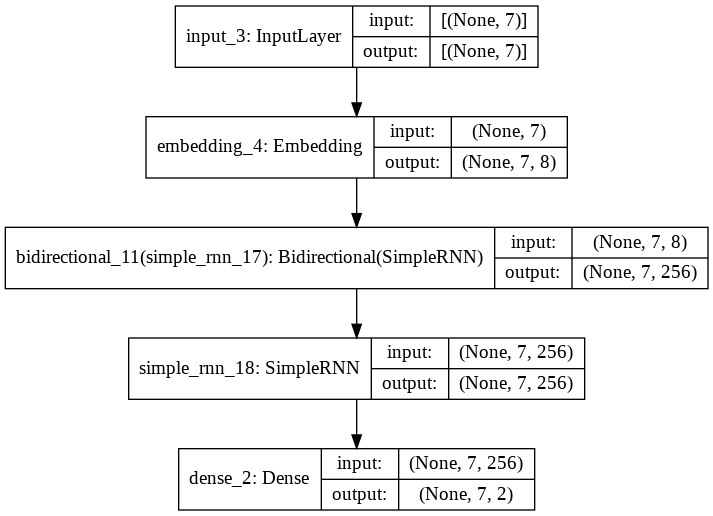

In [82]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [78]:
model.predict(train_inputs)

array([[[0.52180487, 0.4781951 ],
        [0.49663097, 0.503369  ],
        [0.49935666, 0.5006433 ],
        [0.5300422 , 0.46995783],
        [0.47682416, 0.5231758 ],
        [0.51585925, 0.48414072],
        [0.49360505, 0.506395  ]]], dtype=float32)